In [5]:
# made by Gibeom LEE, HI LAB
# 한 폴더 내 모든 csv 파일의 TENG Vpp값을 구할 때 유용합니다.
# +250806 각 frequency도 같이 보여줍니다.

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [7]:
# 폴더 경로
folder_path = r"C:\Users\user\Desktop\Drive파일\HI Lab\0. Projects\0. On going\1. ionic DC-TENG\0. 실험자료\6. data measurement\250921\csv파일"

# 사용자 설정값
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정 / 주변 값보다 얼마나 돌출된 정도여야 피크로 인식할지를 결정
min_prominence = 0.1 # prominence의 최솟값 제한 / std가 너무 작아서 prominence가 너무 낮게 계산되는 경우를 방지
min_distance_sec = 0.15 #인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 1 # Signal-to-Noise Ratio 기준값 / 값이 높을수록 강한 피크만 통과
min_relative_height = 0.1 # 전체 최대 진폭설정 ex) 0.2: 20% 이상 

#그래프
y_range = (-350, 350)
#y_range = (None, None)

0921_10_ac_Vpp: 311.95 V
0921_10_ac_Peak number: 38개
0921_10_ac_표준편차: 6.88
0921_10_ac_주파수: 3.95 Hz


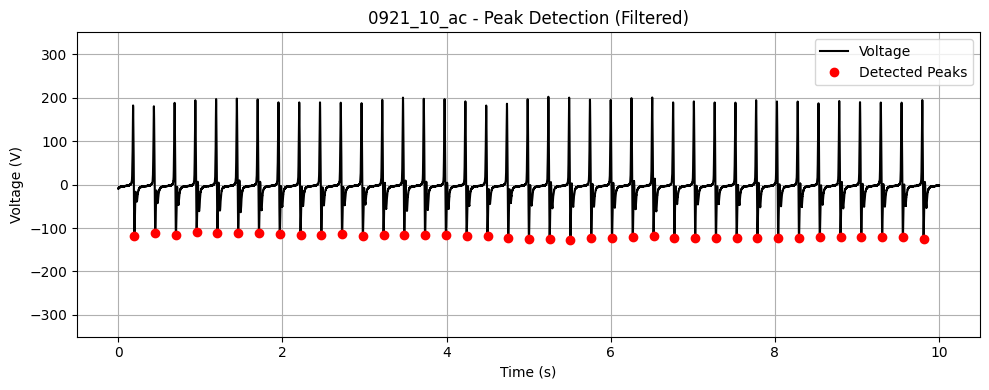

0921_10_ac_2_Vpp: 351.03 V
0921_10_ac_2_Peak number: 39개
0921_10_ac_2_표준편차: 2.99
0921_10_ac_2_주파수: 3.95 Hz


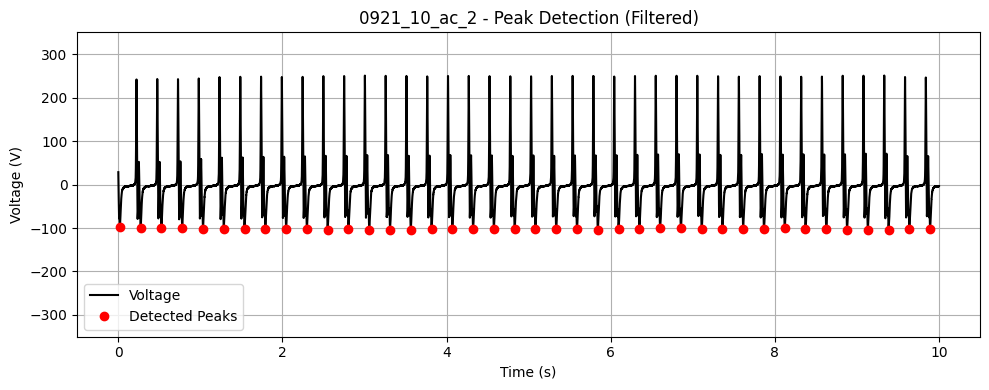

0921_10_dc_Vpp: 0.00 V
0921_10_dc_Peak number: 0개
0921_10_dc_표준편차: 0.00
0921_10_dc_주파수: 0.00 Hz


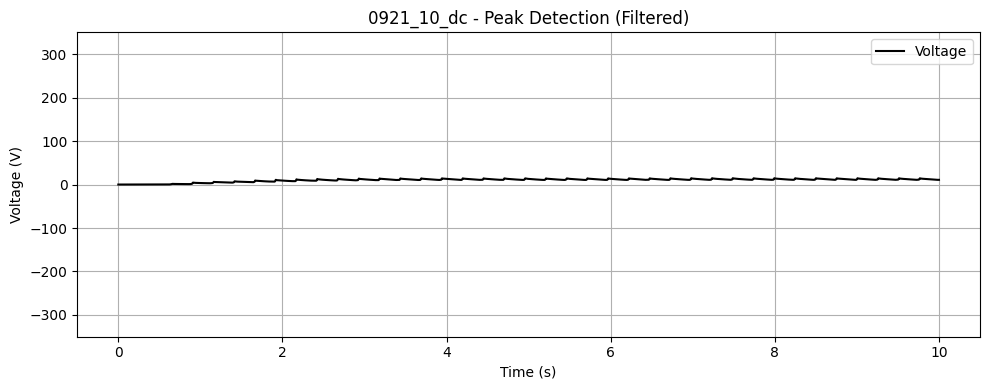

0921_10_dc_2_Vpp: 0.00 V
0921_10_dc_2_Peak number: 0개
0921_10_dc_2_표준편차: 0.00
0921_10_dc_2_주파수: 0.00 Hz


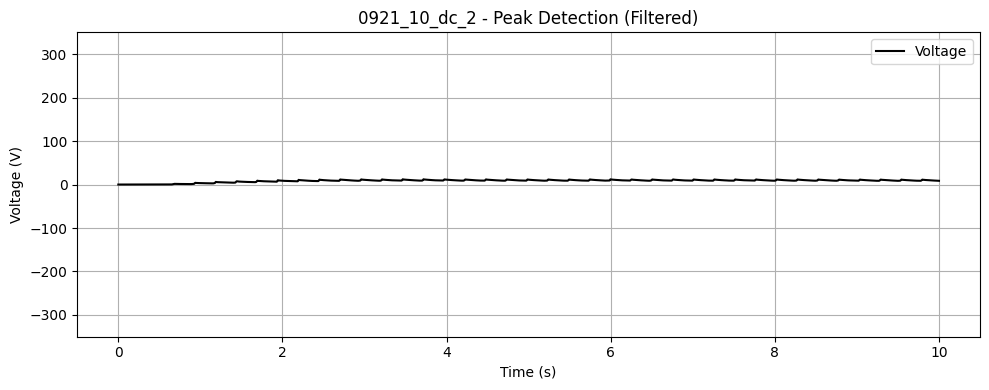

0921_12_ac_Vpp: 349.59 V
0921_12_ac_Peak number: 38개
0921_12_ac_표준편차: 3.02
0921_12_ac_주파수: 3.95 Hz


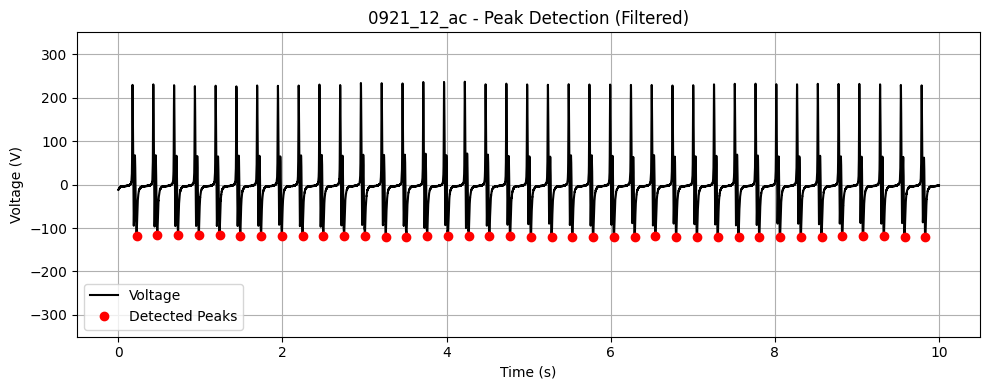

0921_12_ac_2_Vpp: 372.91 V
0921_12_ac_2_Peak number: 39개
0921_12_ac_2_표준편차: 6.14
0921_12_ac_2_주파수: 3.95 Hz


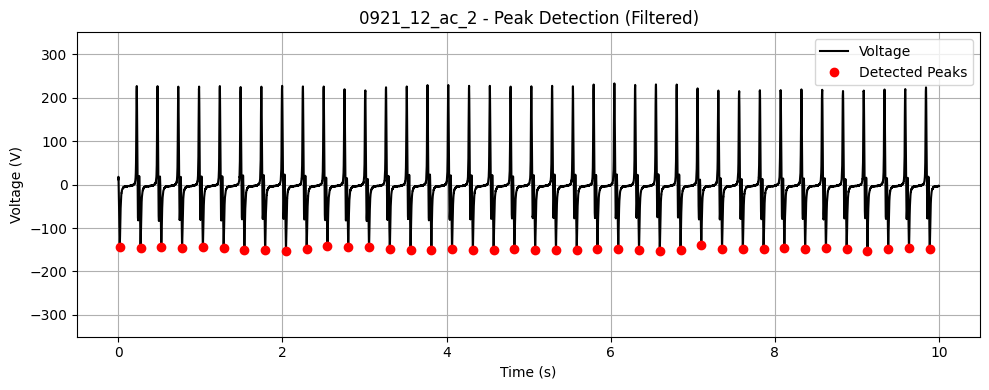

0921_12_dc_Vpp: 0.00 V
0921_12_dc_Peak number: 0개
0921_12_dc_표준편차: 0.00
0921_12_dc_주파수: 0.00 Hz


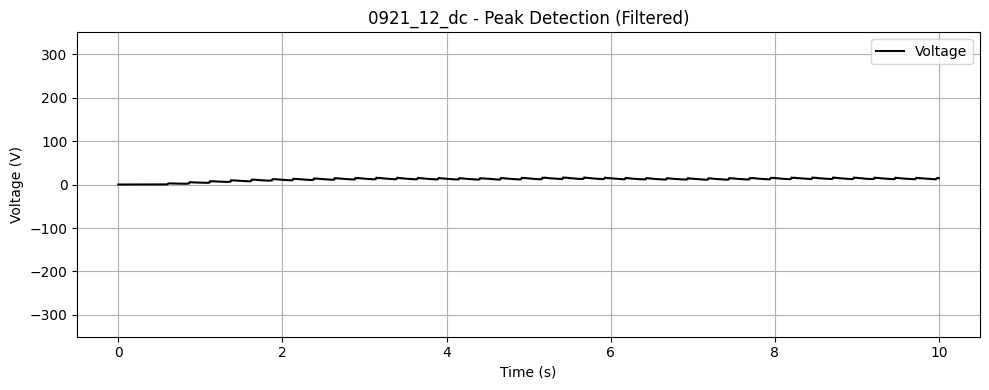

0921_12_dc_2_Vpp: 0.00 V
0921_12_dc_2_Peak number: 0개
0921_12_dc_2_표준편차: 0.00
0921_12_dc_2_주파수: 0.00 Hz


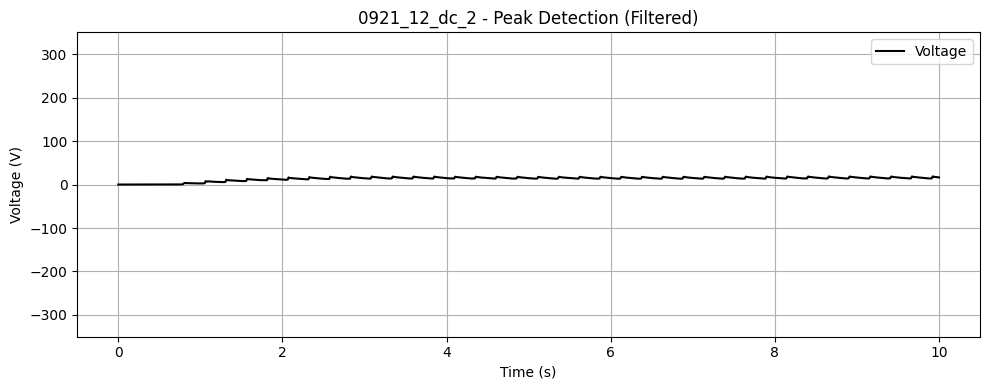

0921_14_ac_Vpp: 380.63 V
0921_14_ac_Peak number: 39개
0921_14_ac_표준편차: 10.86
0921_14_ac_주파수: 3.95 Hz


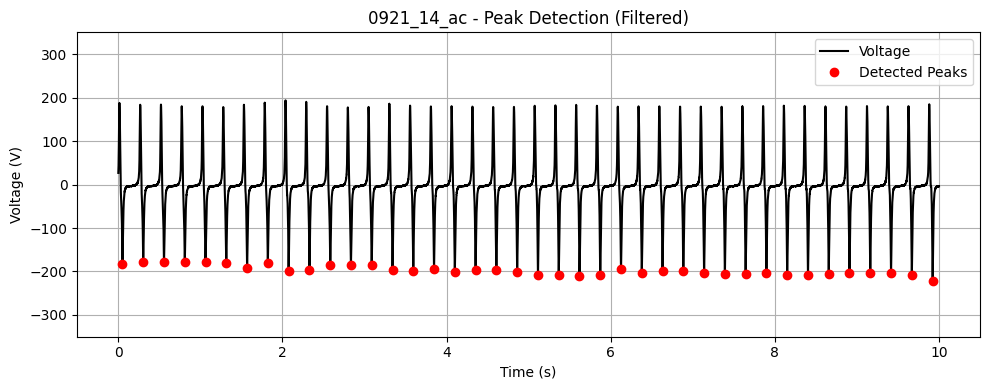

0921_14_ac_2_Vpp: 447.92 V
0921_14_ac_2_Peak number: 38개
0921_14_ac_2_표준편차: 4.83
0921_14_ac_2_주파수: 3.95 Hz


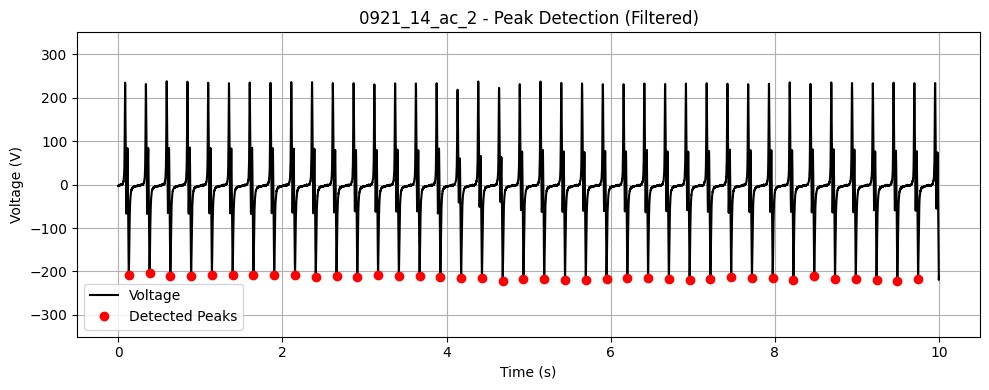

0921_14_dc_Vpp: 0.00 V
0921_14_dc_Peak number: 0개
0921_14_dc_표준편차: 0.00
0921_14_dc_주파수: 0.00 Hz


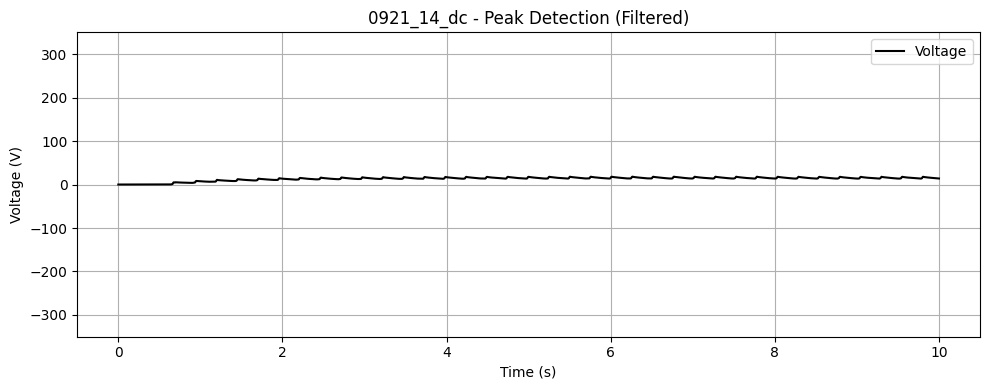

0921_14_dc_2_Vpp: 0.00 V
0921_14_dc_2_Peak number: 0개
0921_14_dc_2_표준편차: 0.00
0921_14_dc_2_주파수: 0.00 Hz


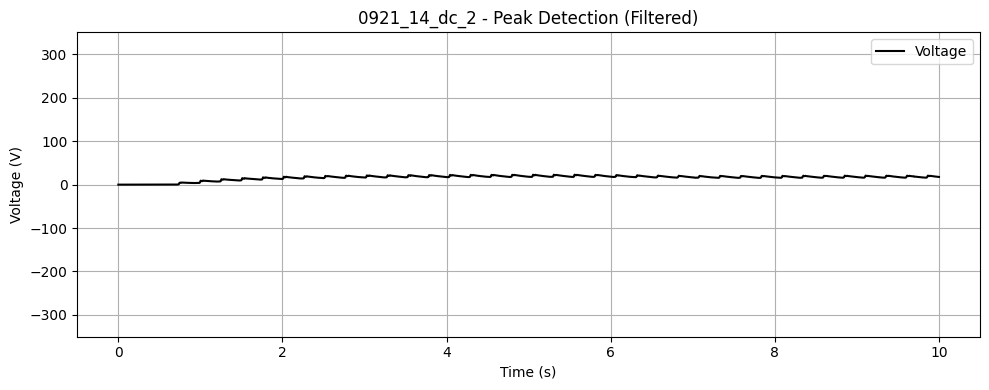

0921_16_ac_Vpp: 449.54 V
0921_16_ac_Peak number: 39개
0921_16_ac_표준편차: 15.07
0921_16_ac_주파수: 3.95 Hz


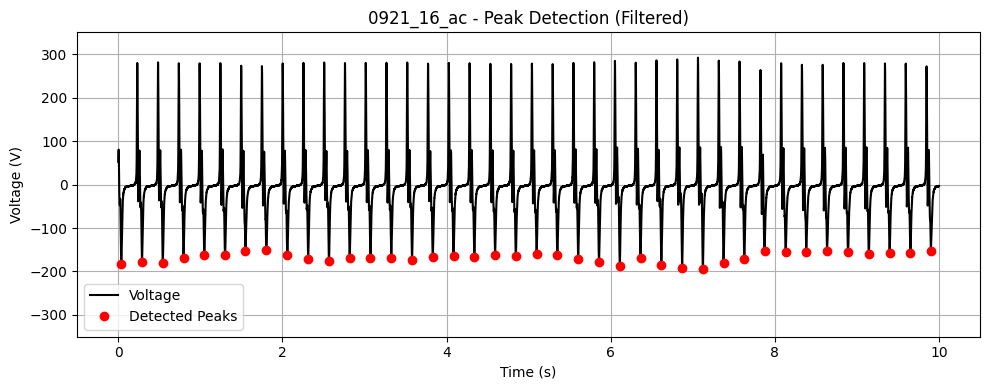

0921_16_ac_2_Vpp: 505.63 V
0921_16_ac_2_Peak number: 39개
0921_16_ac_2_표준편차: 5.12
0921_16_ac_2_주파수: 3.95 Hz


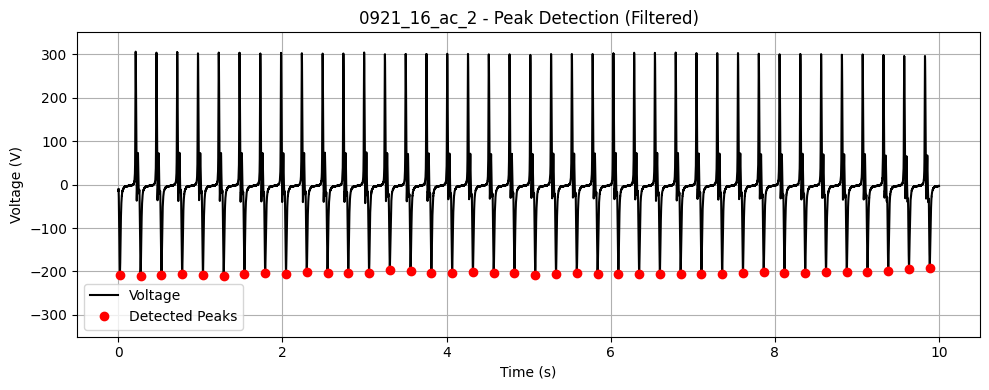

0921_16_dc_Vpp: 0.00 V
0921_16_dc_Peak number: 0개
0921_16_dc_표준편차: 0.00
0921_16_dc_주파수: 0.00 Hz


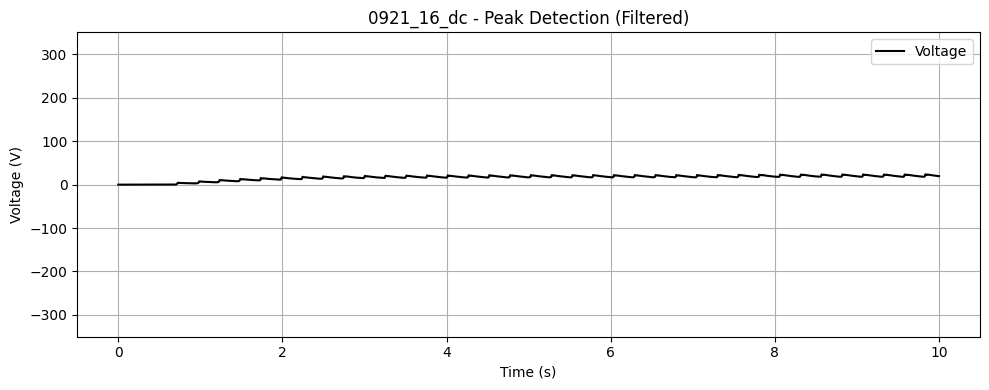

0921_16_dc_2_Vpp: 0.00 V
0921_16_dc_2_Peak number: 0개
0921_16_dc_2_표준편차: 0.00
0921_16_dc_2_주파수: 0.00 Hz


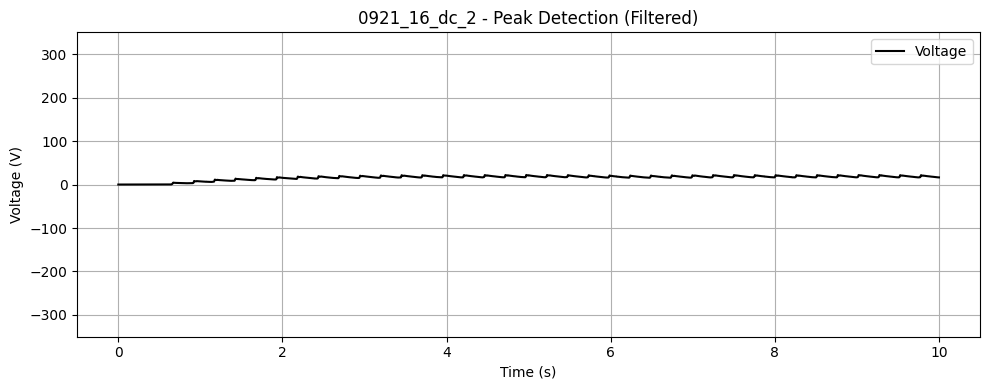

0921_2_ac_Vpp: 89.95 V
0921_2_ac_Peak number: 39개
0921_2_ac_표준편차: 1.36
0921_2_ac_주파수: 3.95 Hz


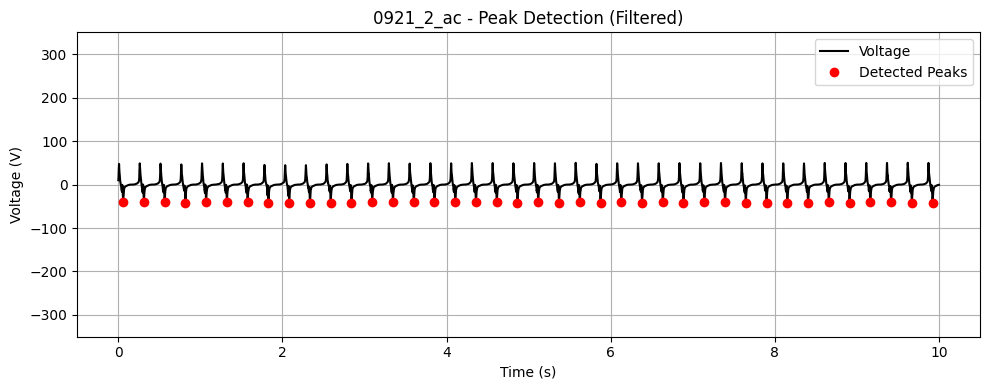

0921_2_ac_2_Vpp: 89.94 V
0921_2_ac_2_Peak number: 42개
0921_2_ac_2_표준편차: 3.08
0921_2_ac_2_주파수: 4.34 Hz


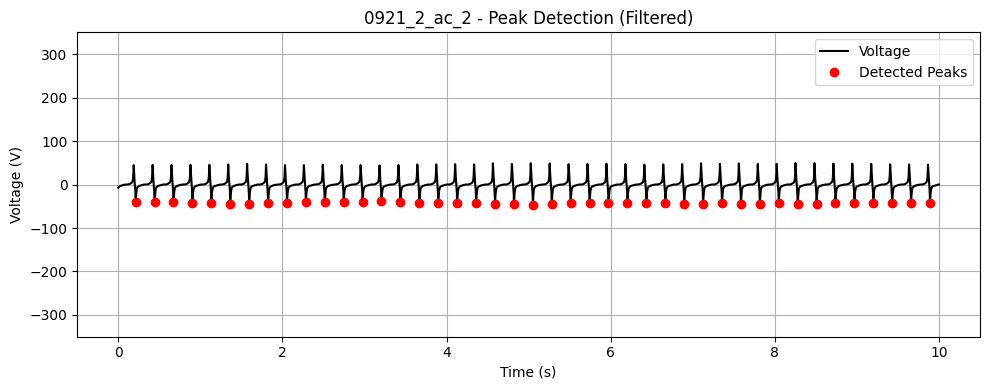

0921_2_dc_Vpp: 0.00 V
0921_2_dc_Peak number: 0개
0921_2_dc_표준편차: 0.00
0921_2_dc_주파수: 0.00 Hz


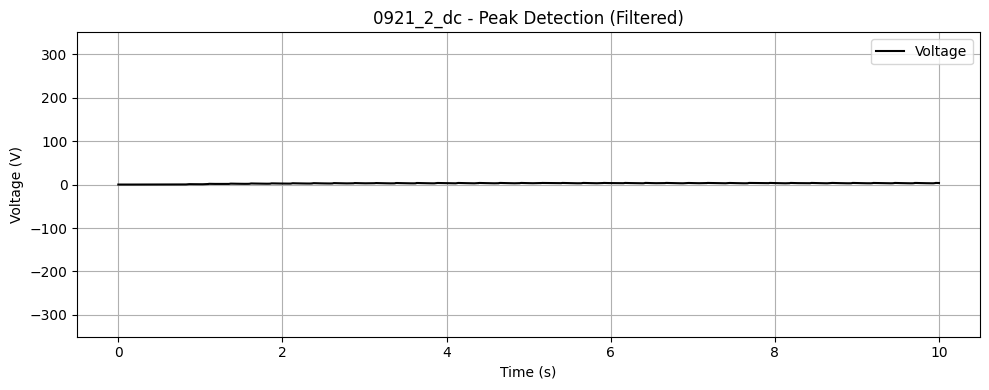

0921_2_dc_2_Vpp: 0.00 V
0921_2_dc_2_Peak number: 0개
0921_2_dc_2_표준편차: 0.00
0921_2_dc_2_주파수: 0.00 Hz


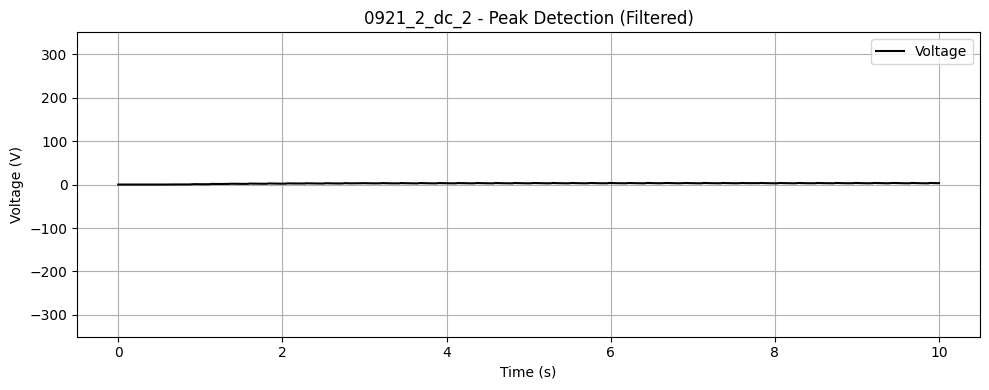

0921_4_ac_Vpp: 178.18 V
0921_4_ac_Peak number: 36개
0921_4_ac_표준편차: 6.41
0921_4_ac_주파수: 3.66 Hz


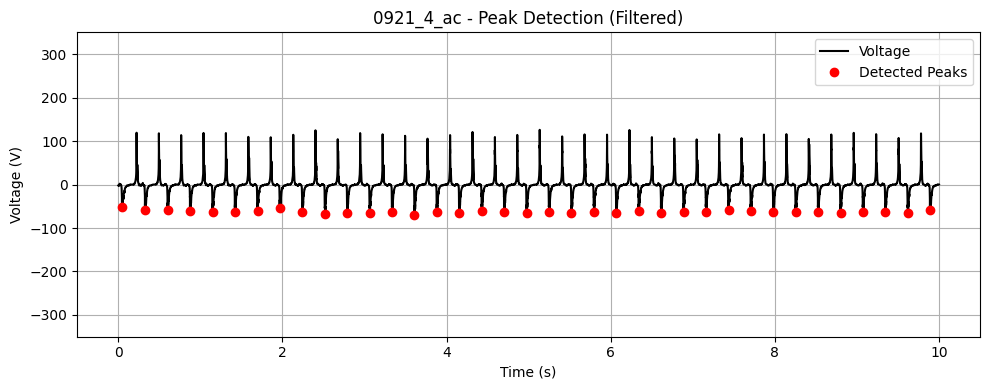

0921_4_ac_2_Vpp: 192.00 V
0921_4_ac_2_Peak number: 43개
0921_4_ac_2_표준편차: 12.40
0921_4_ac_2_주파수: 4.34 Hz


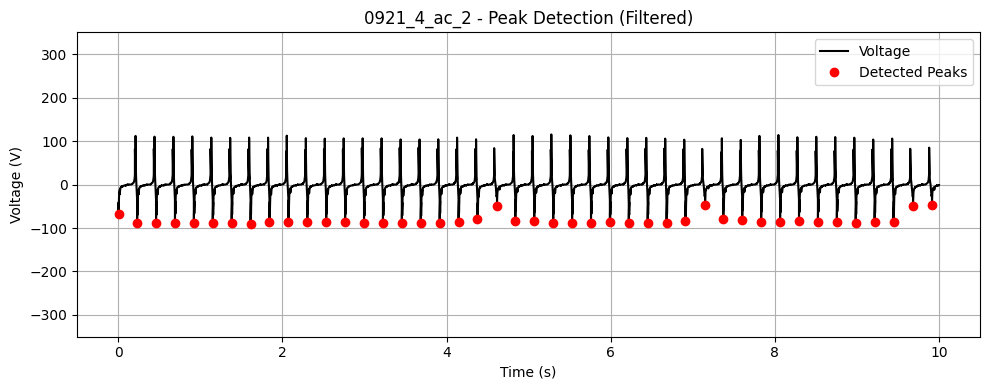

0921_4_dc_Vpp: 0.00 V
0921_4_dc_Peak number: 0개
0921_4_dc_표준편차: 0.00
0921_4_dc_주파수: 0.00 Hz


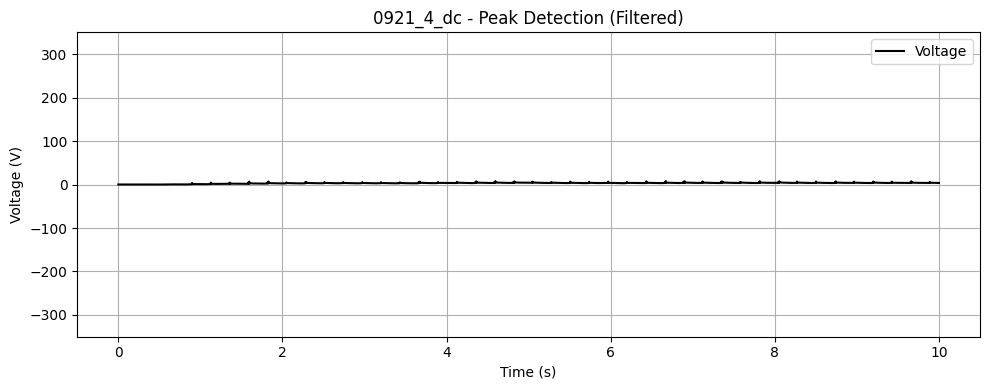

0921_4_dc_2_Vpp: 0.00 V
0921_4_dc_2_Peak number: 0개
0921_4_dc_2_표준편차: 0.00
0921_4_dc_2_주파수: 0.00 Hz


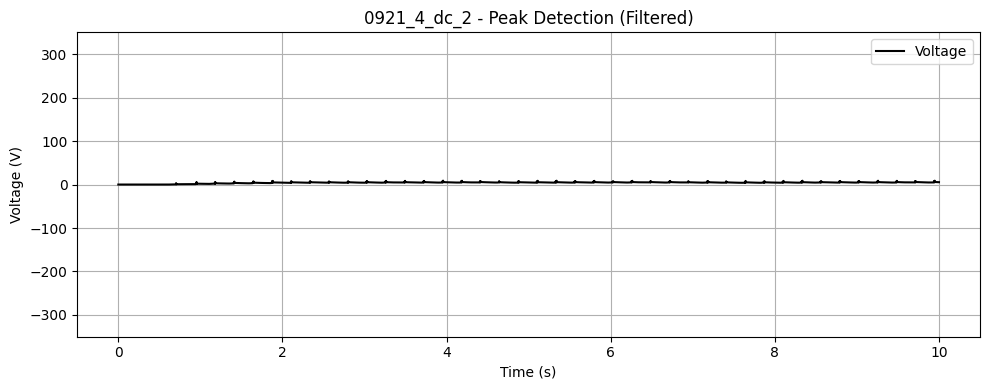

0921_6_ac_Vpp: 242.02 V
0921_6_ac_Peak number: 42개
0921_6_ac_표준편차: 5.95
0921_6_ac_주파수: 4.34 Hz


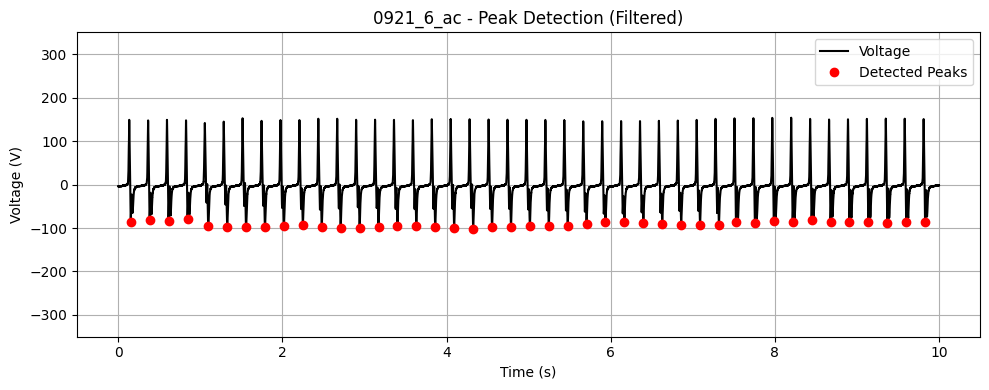

0921_6_ac_2_Vpp: 261.96 V
0921_6_ac_2_Peak number: 39개
0921_6_ac_2_표준편차: 3.26
0921_6_ac_2_주파수: 3.95 Hz


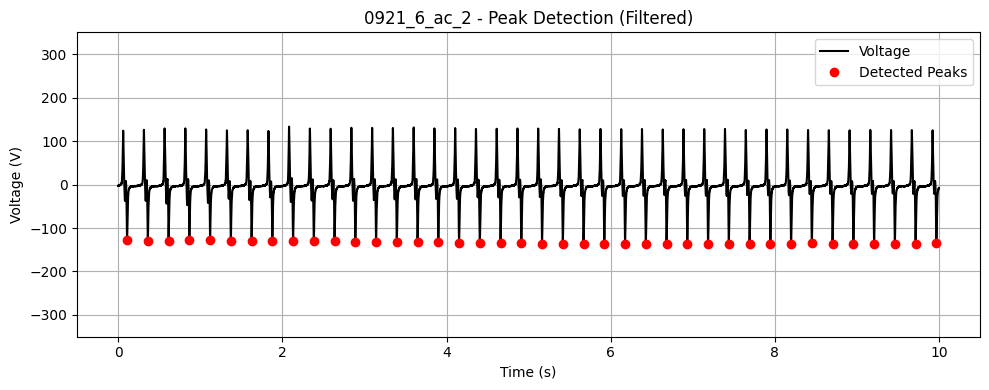

0921_6_dc_Vpp: 0.00 V
0921_6_dc_Peak number: 0개
0921_6_dc_표준편차: 0.00
0921_6_dc_주파수: 0.00 Hz


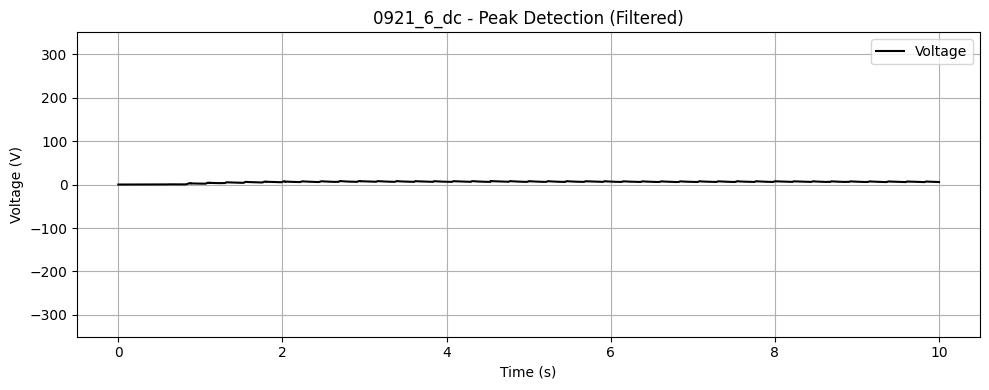

0921_6_dc_2_Vpp: 0.00 V
0921_6_dc_2_Peak number: 0개
0921_6_dc_2_표준편차: 0.00
0921_6_dc_2_주파수: 0.00 Hz


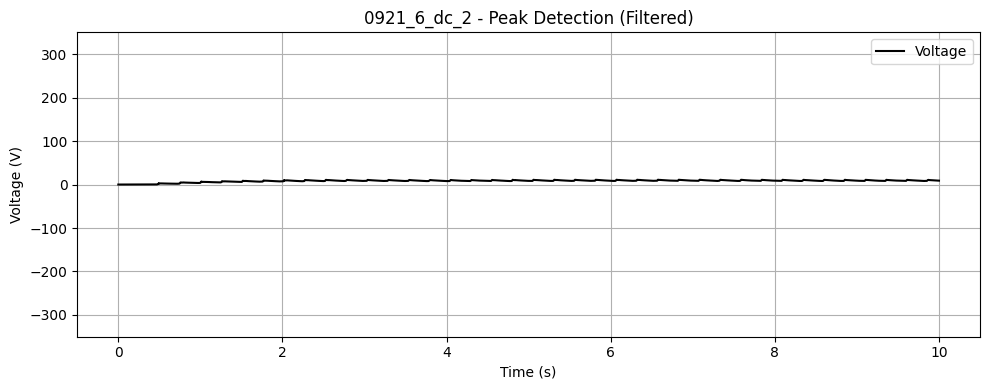

0921_8_ac_Vpp: 253.82 V
0921_8_ac_Peak number: 39개
0921_8_ac_표준편차: 8.03
0921_8_ac_주파수: 3.95 Hz


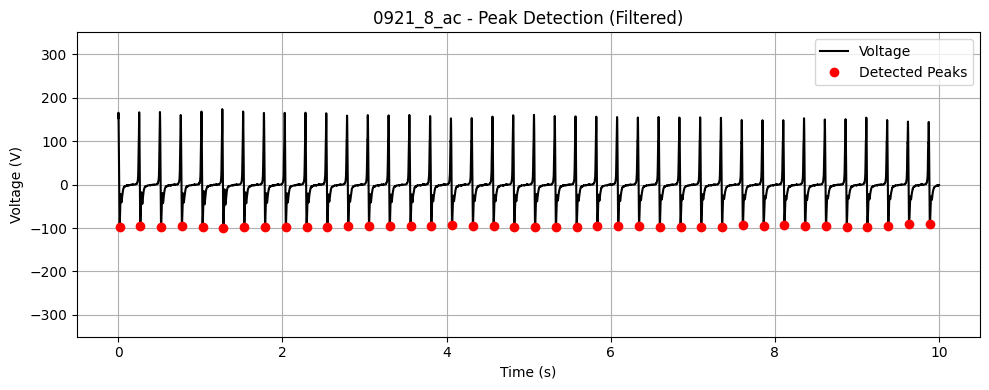

0921_8_ac_2_Vpp: 294.54 V
0921_8_ac_2_Peak number: 39개
0921_8_ac_2_표준편차: 5.70
0921_8_ac_2_주파수: 3.95 Hz


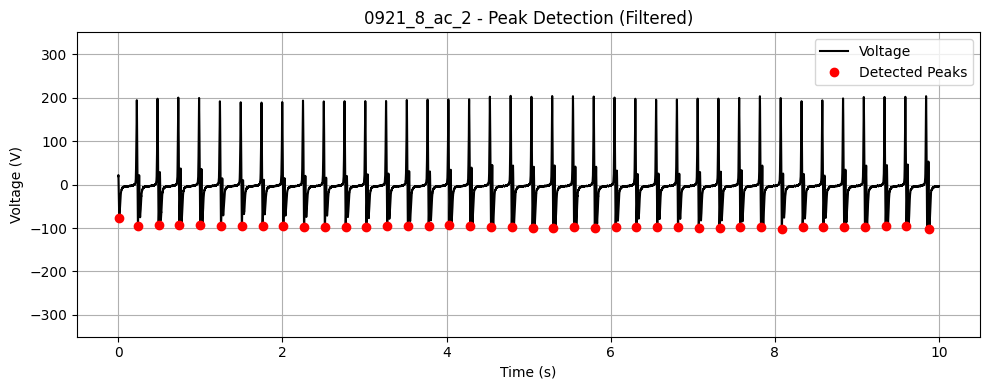

0921_8_dc_Vpp: 0.00 V
0921_8_dc_Peak number: 0개
0921_8_dc_표준편차: 0.00
0921_8_dc_주파수: 0.00 Hz


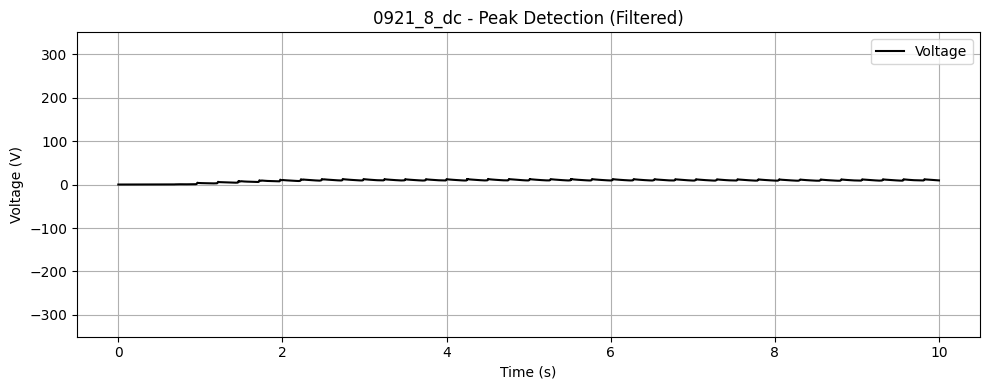

0921_8_dc_2_Vpp: 0.00 V
0921_8_dc_2_Peak number: 0개
0921_8_dc_2_표준편차: 0.00
0921_8_dc_2_주파수: 0.00 Hz


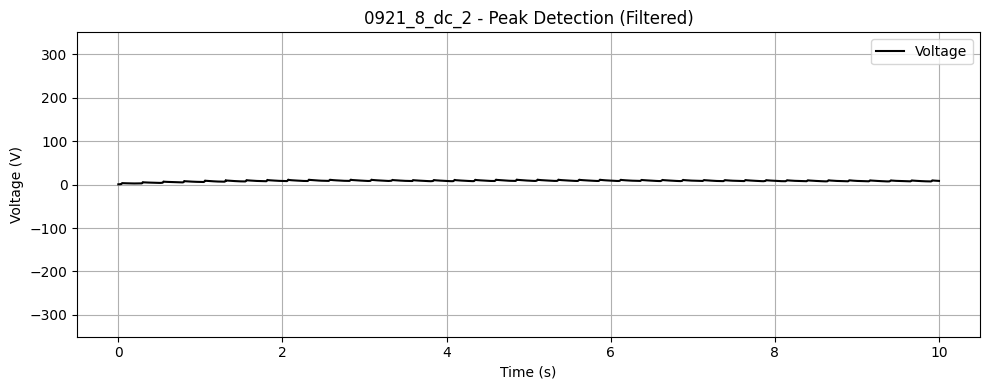

0921_bopp1_Vpp: 64.37 V
0921_bopp1_Peak number: 38개
0921_bopp1_표준편차: 0.83
0921_bopp1_주파수: 3.96 Hz


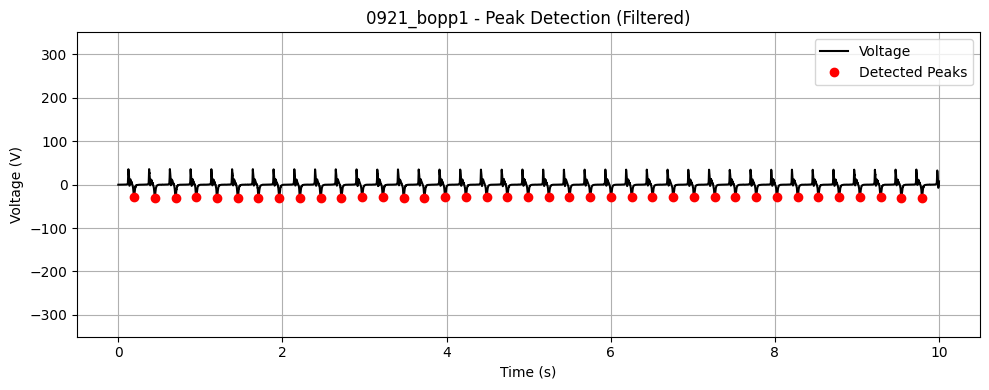

0921_bopp2_Vpp: 62.96 V
0921_bopp2_Peak number: 39개
0921_bopp2_표준편차: 0.51
0921_bopp2_주파수: 3.95 Hz


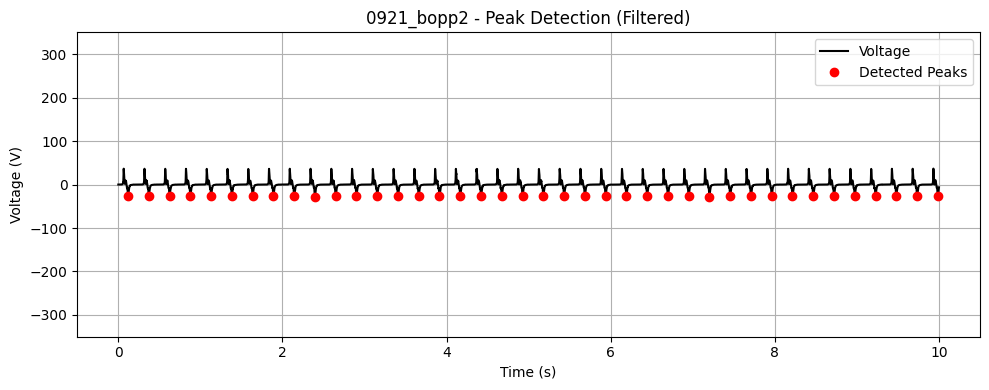

0921_bopp3_Vpp: 52.19 V
0921_bopp3_Peak number: 39개
0921_bopp3_표준편차: 1.67
0921_bopp3_주파수: 3.95 Hz


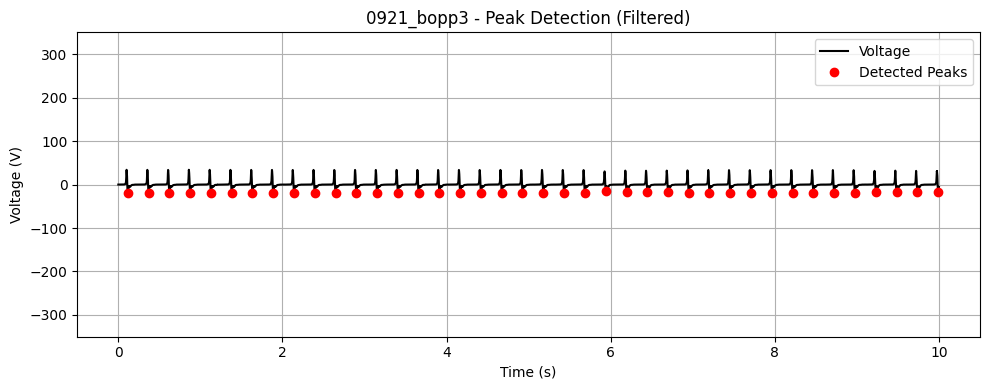

0921_fep1_Vpp: 330.58 V
0921_fep1_Peak number: 38개
0921_fep1_표준편차: 8.89
0921_fep1_주파수: 3.95 Hz


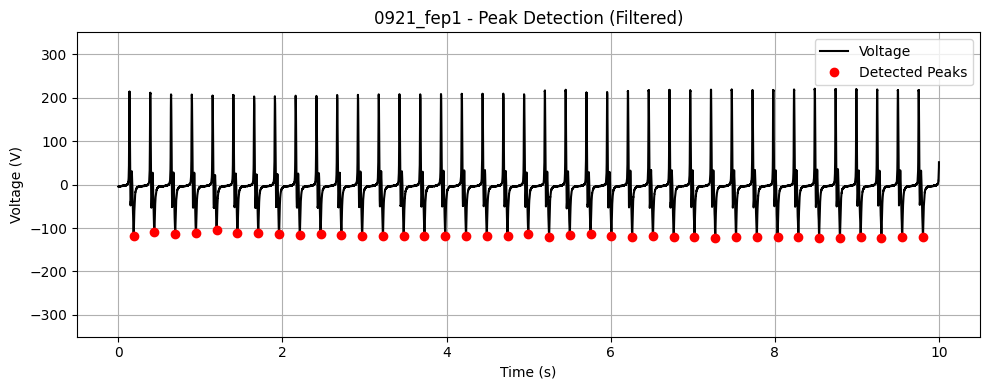

0921_fep2_Vpp: 256.48 V
0921_fep2_Peak number: 38개
0921_fep2_표준편차: 7.62
0921_fep2_주파수: 3.95 Hz


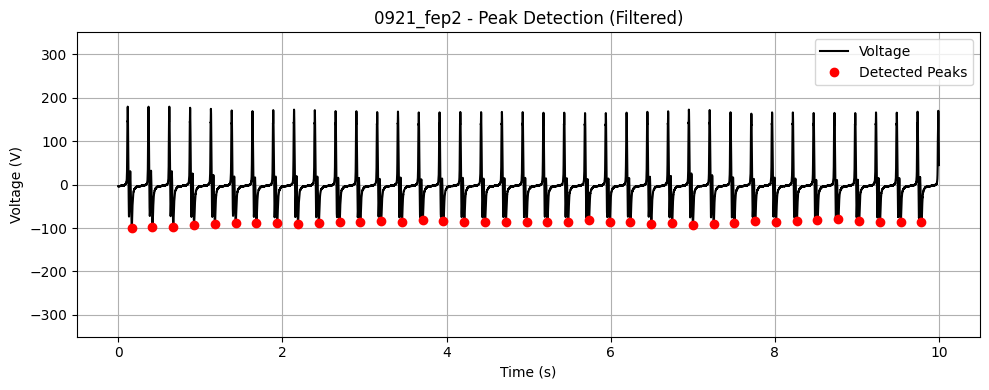

0921_fep3_Vpp: 267.61 V
0921_fep3_Peak number: 38개
0921_fep3_표준편차: 3.24
0921_fep3_주파수: 3.95 Hz


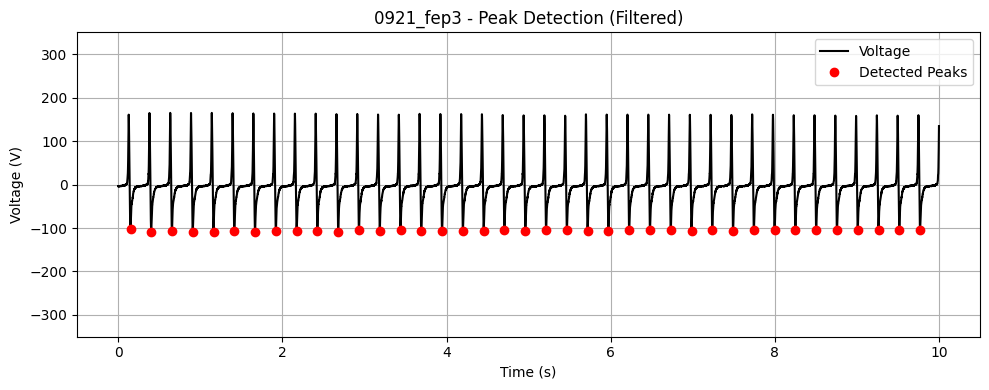

0921_pdms1_Vpp: 66.97 V
0921_pdms1_Peak number: 38개
0921_pdms1_표준편차: 1.76
0921_pdms1_주파수: 3.95 Hz


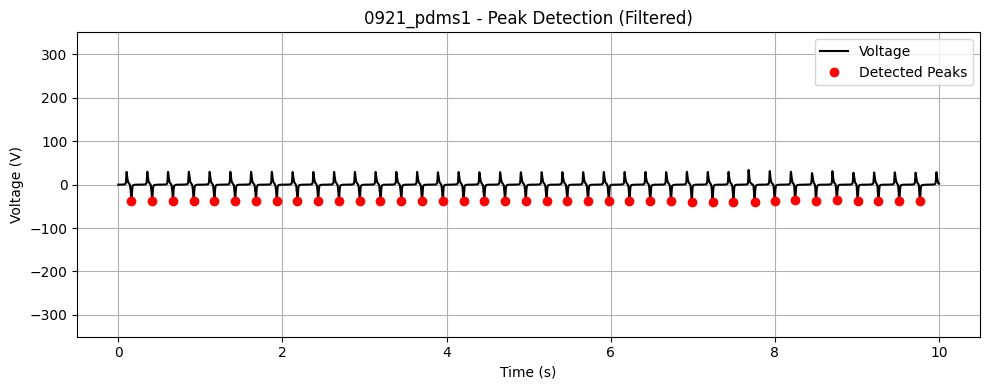

0921_pdms2_Vpp: 145.29 V
0921_pdms2_Peak number: 38개
0921_pdms2_표준편차: 3.02
0921_pdms2_주파수: 3.96 Hz


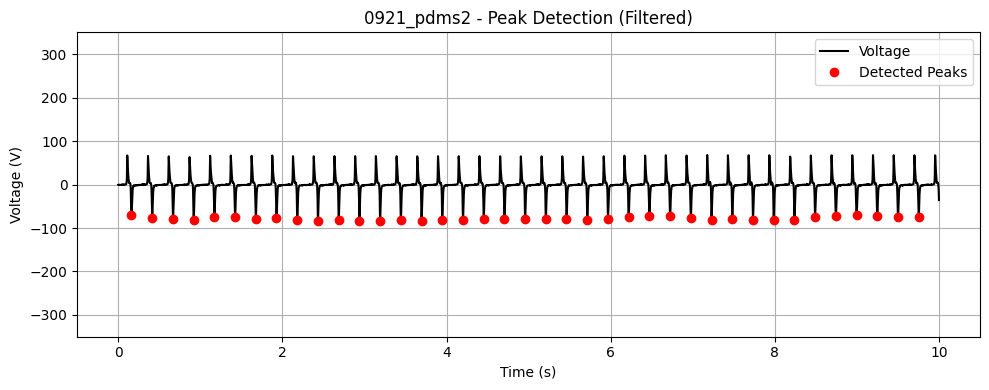

0921_pdms3_Vpp: 47.65 V
0921_pdms3_Peak number: 39개
0921_pdms3_표준편차: 0.28
0921_pdms3_주파수: 3.95 Hz


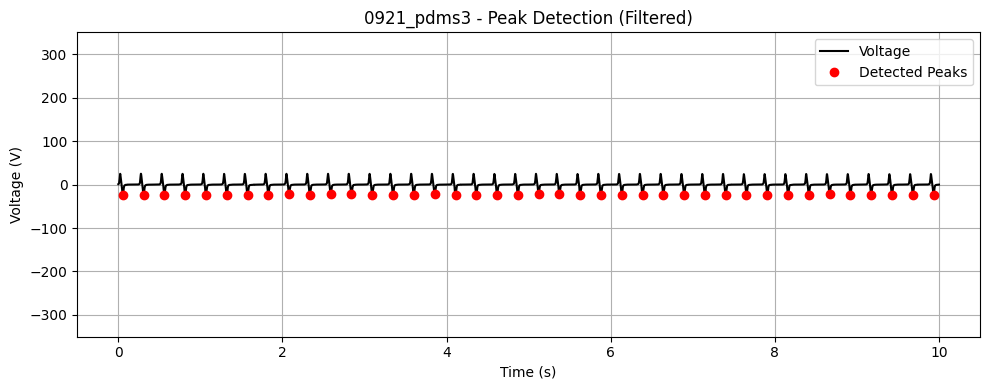

0921_pet1_Vpp: 45.07 V
0921_pet1_Peak number: 38개
0921_pet1_표준편차: 0.72
0921_pet1_주파수: 3.96 Hz


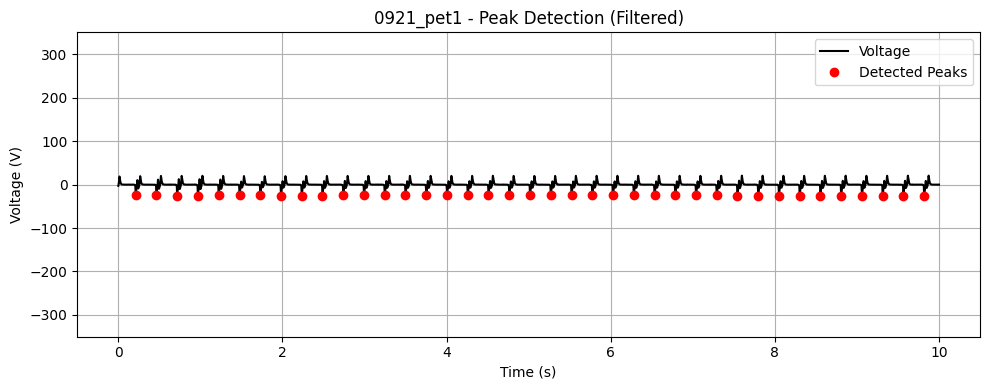

0921_pet2_Vpp: 33.25 V
0921_pet2_Peak number: 39개
0921_pet2_표준편차: 0.88
0921_pet2_주파수: 3.95 Hz


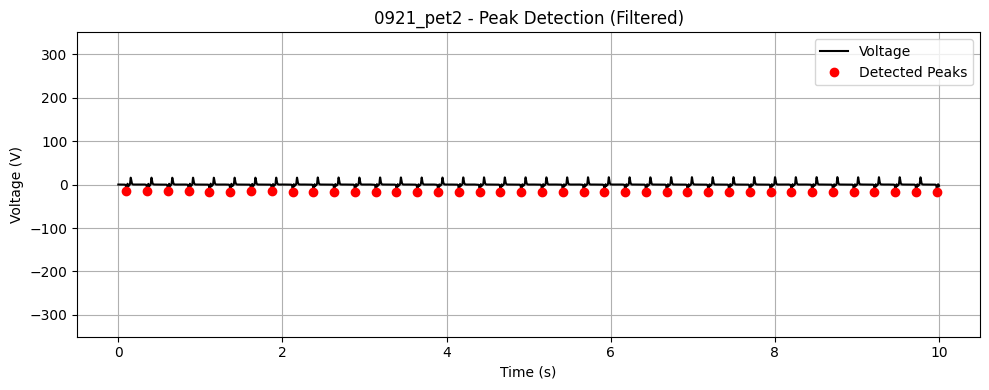

0921_pet3_Vpp: 39.43 V
0921_pet3_Peak number: 38개
0921_pet3_표준편차: 0.43
0921_pet3_주파수: 3.95 Hz


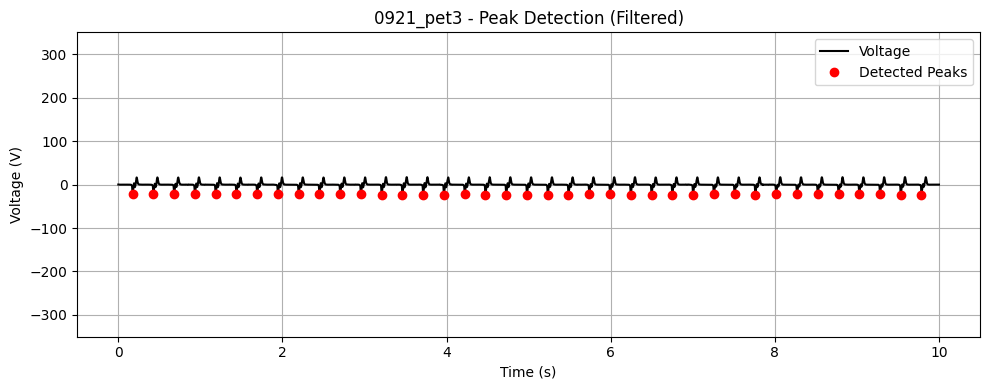

0921_pi1_Vpp: 22.08 V
0921_pi1_Peak number: 39개
0921_pi1_표준편차: 0.89
0921_pi1_주파수: 3.97 Hz


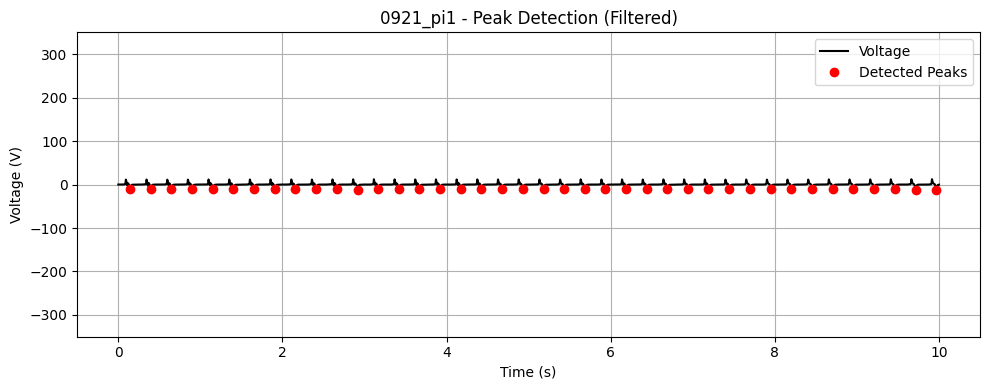

0921_pi2_Vpp: 21.99 V
0921_pi2_Peak number: 38개
0921_pi2_표준편차: 0.59
0921_pi2_주파수: 3.96 Hz


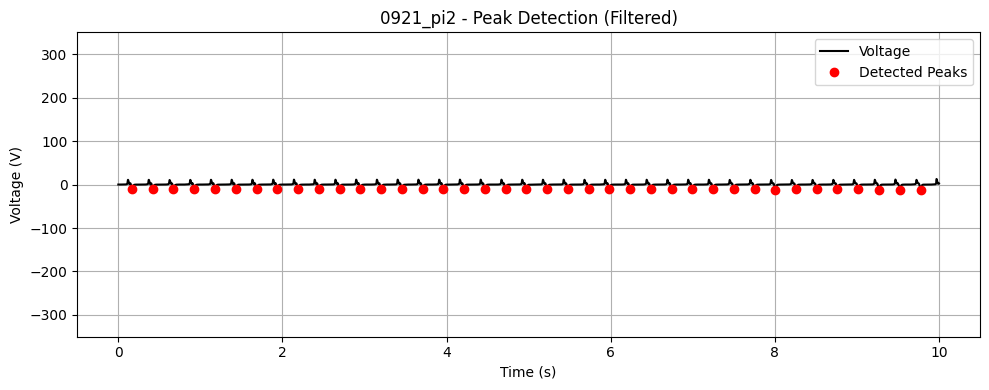

0921_pi3_Vpp: 19.63 V
0921_pi3_Peak number: 38개
0921_pi3_표준편차: 0.47
0921_pi3_주파수: 3.96 Hz


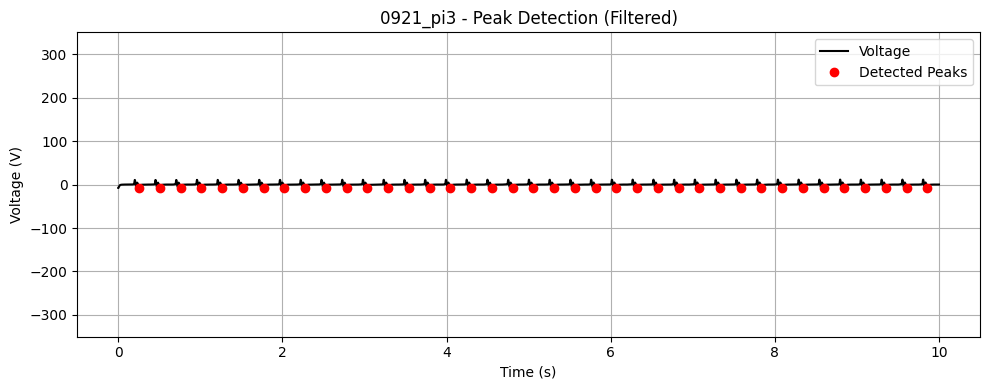

0921_ptfe1_Vpp: 44.59 V
0921_ptfe1_Peak number: 38개
0921_ptfe1_표준편차: 1.87
0921_ptfe1_주파수: 3.95 Hz


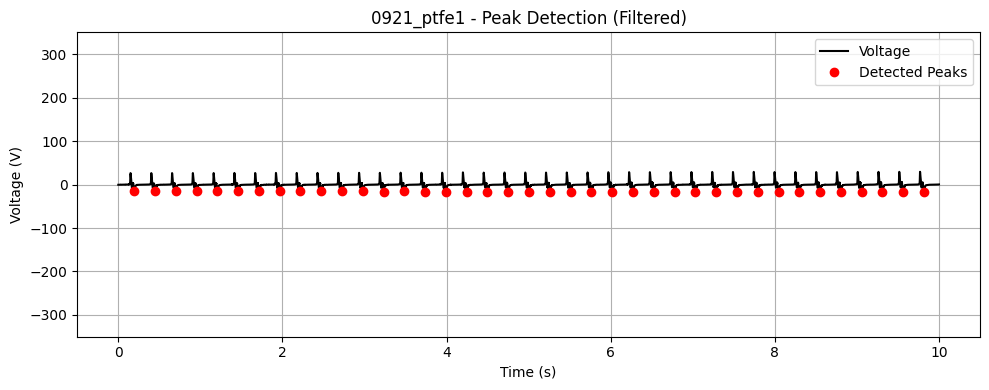

0921_ptfe2_Vpp: 89.42 V
0921_ptfe2_Peak number: 38개
0921_ptfe2_표준편차: 1.28
0921_ptfe2_주파수: 3.95 Hz


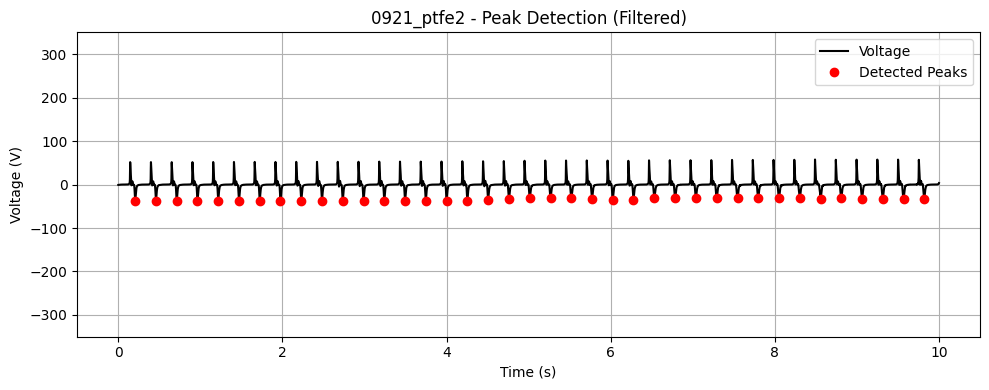

0921_ptfe3_Vpp: 103.03 V
0921_ptfe3_Peak number: 39개
0921_ptfe3_표준편차: 0.73
0921_ptfe3_주파수: 3.95 Hz


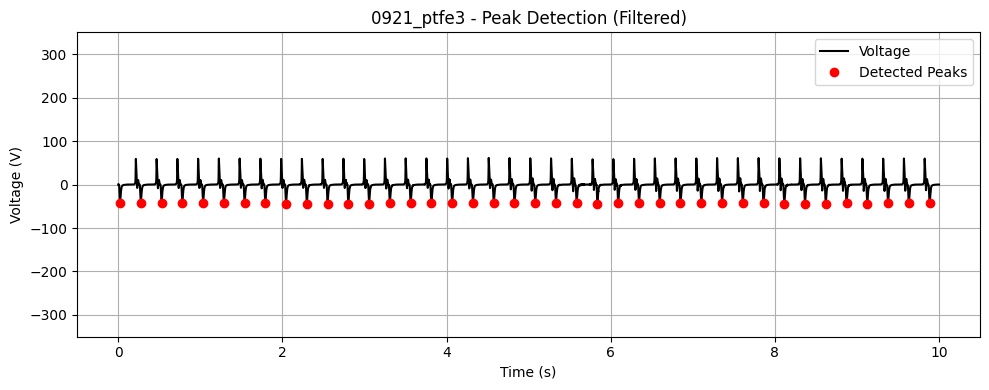


📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록
0921_10_ac.csv_Vpp: 311.95 V | 표준편차: 6.88 V | 주파수: 3.95 Hz
0921_10_ac_2.csv_Vpp: 351.03 V | 표준편차: 2.99 V | 주파수: 3.95 Hz
0921_10_dc.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_10_dc_2.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_12_ac.csv_Vpp: 349.59 V | 표준편차: 3.02 V | 주파수: 3.95 Hz
0921_12_ac_2.csv_Vpp: 372.91 V | 표준편차: 6.14 V | 주파수: 3.95 Hz
0921_12_dc.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_12_dc_2.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_14_ac.csv_Vpp: 380.63 V | 표준편차: 10.86 V | 주파수: 3.95 Hz
0921_14_ac_2.csv_Vpp: 447.92 V | 표준편차: 4.83 V | 주파수: 3.95 Hz
0921_14_dc.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_14_dc_2.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_16_ac.csv_Vpp: 449.54 V | 표준편차: 15.07 V | 주파수: 3.95 Hz
0921_16_ac_2.csv_Vpp: 505.63 V | 표준편차: 5.12 V | 주파수: 3.95 Hz
0921_16_dc.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_16_dc_2.csv_Vpp: 0.00 V | 표준편차: 0.00 V | 주파수: 0.00 Hz
0921_2_ac.csv_Vpp: 8

In [8]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []
file_std_values = []
all_freq_values = []  # 주파수 리스트 저장

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 검출 (음의 피크 대상으로)
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)
        raw_peaks, properties = find_peaks(-voltage, prominence=prom, distance=distance)

        # 피크 필터링
        max_amplitude = np.max(-voltage)
        final_peaks = []
        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = -voltage[i]
            if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # Vpp 계산
        vpp_list = []
        if len(final_peaks) > 1:
            for i in range(len(final_peaks) - 1):
                start = final_peaks[i]
                end = final_peaks[i + 1]
                vpp = np.max(voltage[start:end + 1]) - np.min(voltage[start:end + 1])
                vpp_list.append(vpp)
        elif len(final_peaks) == 1:
            # 피크가 하나일 때 Vpp 계산
            vpp_list.append(np.max(voltage) - np.min(voltage))

        mean_vpp = np.mean(vpp_list) if vpp_list else 0
        std = np.std(vpp_list, ddof=1) if len(vpp_list) > 1 else 0  # 표준편차 계산

        # 주파수 계산
        if len(peak_times) < 2:
            mean_freq = 0
        else:
            periods = np.diff(peak_times)
            mean_freq = np.mean(1 / periods)

        # 결과 출력
        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Vpp: {mean_vpp:.2f} V")
        print(f"{base_name}_Peak number: {len(vpp_list):.0f}개")
        print(f"{base_name}_표준편차: {std:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        # 결과 저장
        all_vpp_values.append(mean_vpp)
        file_std_values.append(std)
        all_freq_values.append(mean_freq)

        # -------------------------------
        # 그래프 출력
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, color='black', label='Voltage')
        if len(final_peaks) > 0:
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', label='Detected Peaks')
        plt.title(f"{base_name} - Peak Detection (Filtered)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        if y_range is not None:
            plt.ylim(y_range)  # y_range가 None일 때는 실행 안 함
        plt.ylim(y_range)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print("📊 모든 파일의 평균 Vpp, 표준편차, 평균 주파수 목록")
for i in range(len(all_vpp_values)):
    print(f"{csv_files[i]}_Vpp: {all_vpp_values[i]:.2f} V | 표준편차: {file_std_values[i]:.2f} V | 주파수: {all_freq_values[i]:.2f} Hz")

if all_vpp_values:
    overall_mean_vpp = np.mean(all_vpp_values)
    overall_std_vpp = np.std(all_vpp_values, ddof=1)
    overall_mean_freq = np.mean(all_freq_values) if all_freq_values else 0
    overall_std_freq = np.std(all_freq_values, ddof=1) if all_freq_values else 0

    print("\n==============================")
    print(f"📈 전체 평균 Vpp: {overall_mean_vpp:.2f} V")
    print(f"📉 표준편차 (Vpp): {overall_std_vpp:.2f} V")
    print(f"🎵 전체 평균 주파수: {overall_mean_freq:.2f} Hz")
    print(f"🎯 표준편차 (주파수): {overall_std_freq:.2f} Hz")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")
